# Physics-Informed Neural Network (PINN)
The [article](https://www.sciencedirect.com/science/article/pii/S0021999118307125) "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations" by Raissi, Perdikaris, and Karniadakis (2019) offered a landmark milestone in the advancement of solving physics-based PDEs using the methods of deep learning.

This notebook builds a PINN for solving a paradigm spatiotemporal PDE arising in fluid dynamics, Burgers equation, reproducing the work in Raissi et al.'s paper.  The L-BFGS algorithm using full batches is used for training.

The PINN's solution compares very favorably with that of high-fidelity direct numerical simulation of the Burgers equation.  The DNS is performed using standard pseudospectral techniques.

## Burgers Equation
Burgers Equation is
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

Somewhat more generally, a PDE in one dimension can be written as
$$ \partial_t u(t, x) + \mathcal{N}[u] = 0,$$
with 
\begin{align}
u(0, x) &= h(x) \\
u(t, a) &= u_L(t) \\
u(t, b) &= u_R(t)
\end{align}
where $N$ is some nonlinear differential operator, and $h, u_L, and u_R$ give the initial and boundary conditions.  If we define $f$ by

$$ f = \partial_t u + \mathcal{N} $$,

the PDE is determined by $f=0$.

The PINN works by first setting up a standard feedforward network architecture to predict the value $u$ given input arguments $(t,x)$.  Let the prediction of the neural network be $\hat{u} = g(X, \theta)$, where $X=(t,x)$ and $\theta$ are the network weights.

The *training data* consists of the initial and boundary conditions: $\{X^i; u^i\}$, and the standard Mean-Square Error (MSE) makes up part of the loss function:

$$ MSE_u = \frac{1}{N_u} \sum_{i=1}^{N_u} (\hat{u}^i - u^i)^2, $$

where $\hat{u}^i = g(X^i, \theta)$.  The following figure from Raissi et al. shows that the training data is sampled from the initial and boundary conditions.  100 points are used for the training data.
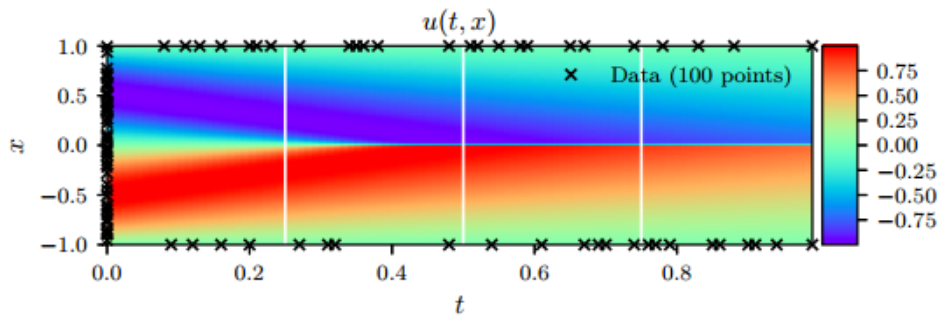

## Incorporating Physics
The "big idea" of PINNs is to not only use data, but to incorporate the *physics constraint*, such as conservation laws, which we know in the form of the PDE.  This can be incorporated through an auxiliary contribution to the loss function,

$$ MSE_f = \frac{1}{N_b} \sum_{i=1}^{N_b} |g(t_f^i, x_f^i)|^2, $$

where we have sampled the interior of the domain at a collection of points $\{t_f^i, x_f^i\}$.  Latin hypercube sampling can be used to determine these points.  We use 10,000 points here.

The second big idea is to use the tools of automatic differentiation that is built into modern machine-learning frameworks.  Calculating the function $g$, which involves partial derivatives in space or time, can then be *automatically* and *exactly* carried out, without any discretization of space and time.

## Total loss function
The total loss function incorporates the training error (whether the initial and boundary conditions are satisfied), and the physics error (whether the PDE is satisfied in the interior of the domain)

$$ J = MSE_u + MSE_f $$

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
matplotlib.style.use('ggplot')
%config Completer.use_jedi = False

import tensorflow as tf
pi = tf.constant(np.pi)
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
#tf.keras.backend.set_floatx("float64")  # use float64 if desired

import scipy.stats.qmc  # for latin hypercube sampling

### Creating a function usable by `tfp.optimizer.lbfgs_minimize`
Because we want to use the L-BFGS minimize in `tensorflow-probability`, as well a a custom loss function, we need to create an approprate function.  The Adam optimizer did not work as well in my experience; it failed to get good convergence.

A typical keras model has signature `y = model(x)`, but to use our optimizer we need a function with signature `y = model(weights)`, where `weights` is a 1D array of parameters to be optimized.  The following code accomplishes that.

In [3]:
def function_factory(model, loss, train_x, train_y,
                    f_func, x_f, t_f):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
          
            # signature for custom_loss:  (train_x, train_y, model, f_func, t_f, x_f)
            loss_value = loss(train_x, train_y, model, f_func, t_f, x_f)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        # grads is a list of tensors; dynamic stitch interleaves into a 1D tensor
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        if f.iter % 100 == 0:
            tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []
    return f

In [4]:
# define custom loss function
def custom_loss(x_train, y_train, model, f, t_f, x_f):
    loss1 = data_loss(model(x_train), y_train)
    loss2 = physics_loss(f, t_f, x_f)
    return loss1 + loss2

def data_loss(y_pred, y_target):
    """Compute the MSE due to boundary/initial data."""
    return tf.reduce_mean(tf.square(y_target - y_pred))

def physics_loss(f, t_f, x_f):
    """Loss due to physics constraint (PDE constraint)."""
    # Compute f(), error is MSE of f on (t_f, x_f) values
    f = f_func(t_f, x_f)
    return tf.reduce_mean(tf.square(f))

In [9]:
def ufunc(t, x):
    # same as model(X), but with individual arguments (t, x)
    X = tf.stack((t, x), axis=-1)
    uval = model(X)
    return uval

def f_func(t, x):
    # compute f, using automatic differentiation built into tensorflow
    with tf.GradientTape(watch_accessed_variables=False) as t2:
        t2.watch((t, x))
        with tf.GradientTape(watch_accessed_variables=False) as t1:
            t1.watch((t, x))
            u = ufunc(t, x)
        [u_t, u_x] = t1.gradient(u, [t, x])
    
    u_xx = t2.gradient(u_x, x)
    
    fval = u_t + tf.squeeze(u)*u_x  -  (0.01/pi) * u_xx
    return fval

# Training data
- Input Training Data:  $(t_u, x_u)$: 2 numbers with $N_u$ samples.  So Training Data X has shape $(N_u, 2)$
- Output training data:  $(u)$: 1 number with $N_u$ samples.  Y has shape $(N_u, 1)$.

Use 100 total samples.

In [10]:
s1 = 50  # 50
s2 = 25  # 25
s3 = 25  # 25

# generate the data
# 50 points from initial condition t=0
x1 = np.random.uniform(low=-1.0, high=1.0, size=(s1,))
t1 = np.zeros_like(x1)
u1 = -np.sin(np.pi * x1)

# 25 points from boundary x=-1
t2 = np.random.uniform(low=0, high=1.0, size=(s2,))
x2 = -np.ones_like(t2)
u2 = np.zeros_like(t2)  # Dirichlet boundary conditions

# 25 points from boundary x=1
t3 = np.random.uniform(low=0, high=1.0, size=(s3,))
x3 = np.ones_like(t3)
u3 = np.zeros_like(t3)  # Dirichlet boundary conditions

x = np.concatenate((x1, x2, x3))
t = np.concatenate((t1, t2, t3))
u = np.concatenate((u1, u2, u3))

# put into the right format for training
X = np.stack((t, x), axis=1)
Y = u.reshape((s1 + s2 + s3, 1))
print(X.shape, Y.shape)
Nu, ninputs = X.shape

(100, 2) (100, 1)


In [5]:
def ufunc(t, x):
    # define neural_net
    #print(t.shape)
    #print(x.shape)
    X = tf.stack((t, x), axis=-1)
    #X = tf.concat([t, x], axis=1)
    uval = model(X)
    return uval

def f_func(t, x):
    # https://www.tensorflow.org/guide/advanced_autodiff
    with tf.GradientTape(watch_accessed_variables=False) as t2:
        t2.watch((t, x))
        with tf.GradientTape(watch_accessed_variables=False) as t1:
            t1.watch((t, x))
            u = ufunc(t, x)
        [u_t, u_x] = t1.gradient(u, [t, x])
    
    u_xx = t2.gradient(u_x, x)
    
    fval = u_t + tf.squeeze(u)*u_x  -  (0.01/pi) * u_xx
    return fval

### Shape of data
- Input Training Data:  $(t_u, x_u)$: 2 numbers with $N_u$ samples.  So Training Data X has shape $(N_u, 2)$
- Output training data:  $(u)$: 1 number with $N_u$ samples.  Y has shape $(N_u, 1)$.

In [5]:
s1 = 50  # 50
s2 = 25  # 25
s3 = 25  # 25

# generate the data
# 50 points from initial condition t=0
x1 = np.random.uniform(low=-1.0, high=1.0, size=(s1,))
t1 = np.zeros_like(x1)
u1 = -np.sin(np.pi * x1)

# 25 points from boundary x=-1
t2 = np.random.uniform(low=0, high=1.0, size=(s2,))
x2 = -np.ones_like(t2)
u2 = np.zeros_like(t2)  # Dirichlet boundary conditions

# 25 points from boundary x=1
t3 = np.random.uniform(low=0, high=1.0, size=(s3,))
x3 = np.ones_like(t3)
u3 = np.zeros_like(t3)  # Dirichlet boundary conditions

x = np.concatenate((x1, x2, x3))
t = np.concatenate((t1, t2, t3))
u = np.concatenate((u1, u2, u3))

# put into the right format for training
X = np.stack((t, x), axis=1)
Y = u.reshape((s1 + s2 + s3, 1))
print(X.shape, Y.shape)
Nu, ninputs = X.shape

(100, 2) (100, 1)


## Latin hypercube sampling
For points $t_f \in [0, 1]$ and $x_f \in [-1, 1]$.  Use 6,000 or 10,000 points

In [11]:
Nsamples = 6000  # 10000
sampler = scipy.stats.qmc.LatinHypercube(d=2)
sample = sampler.random(n=Nsamples)
# scale so t in [0,1], x in [-1, 1]
l_bounds = [0, -1]
u_bounds = [1, 1]
sample = scipy.stats.qmc.scale(sample, l_bounds, u_bounds)
t_f = sample[:, 0]
x_f = sample[:, 1]

# convert to tensors
t_f = tf.convert_to_tensor(t_f, dtype=tf.float32)
x_f = tf.convert_to_tensor(x_f, dtype=tf.float32)   # or dtype = tf.float64
x_f.shape

TensorShape([6000])

## Define the neural network architecture
The network architecture here is a simple feedforward network, with 8 hidden layers of 20 units each, using a tanh activation.

In [12]:
act = "tanh"

def build_model():
    inputs = keras.Input(shape=(2,))
    x = layers.Dense(20, activation=act)(inputs)
    x = layers.Dense(20, activation=act)(x)
    x = layers.Dense(20, activation=act)(x)
    x = layers.Dense(20, activation=act)(x)
    x = layers.Dense(20, activation=act)(x)
    x = layers.Dense(20, activation=act)(x)
    x = layers.Dense(20, activation=act)(x)
    x = layers.Dense(20, activation=act)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
model = build_model()
#model.summary()

# Train the model using L-BFGS

In [13]:
func = function_factory(model, custom_loss, X, Y, f_func, x_f, t_f)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func, initial_position=init_params, max_iterations=4000,
    f_relative_tolerance=1e-10, x_tolerance=1e-10)

# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

Iter: 100 loss: 0.0866021067
Iter: 200 loss: 0.0571030155
Iter: 300 loss: 0.0396275967
Iter: 400 loss: 0.0260089152
Iter: 500 loss: 0.0200954638
Iter: 600 loss: 0.013025824
Iter: 700 loss: 0.00940694474
Iter: 800 loss: 0.00740302633
Iter: 900 loss: 0.00549208093
Iter: 1000 loss: 0.00456520775
Iter: 1100 loss: 0.00358854886
Iter: 1200 loss: 0.0029400324
Iter: 1300 loss: 0.00240131
Iter: 1400 loss: 0.0019798046
Iter: 1500 loss: 0.00160741876
Iter: 1600 loss: 0.00146540755
Iter: 1700 loss: 0.0013263477
Iter: 1800 loss: 0.00118957413
Iter: 1900 loss: 0.00108428393
Iter: 2000 loss: 0.000971591217
Iter: 2100 loss: 0.000935996766
Iter: 2200 loss: 0.000816101208
Iter: 2300 loss: 0.000758733659
Iter: 2400 loss: 0.000717657618
Iter: 2500 loss: 0.000665637199
Iter: 2600 loss: 0.000619552156
Iter: 2700 loss: 0.000596129859
Iter: 2800 loss: 0.000582932727
Iter: 2900 loss: 0.000559583772
Iter: 3000 loss: 0.000530185469
Iter: 3100 loss: 0.000495778746
Iter: 3200 loss: 0.000462100288
Iter: 3300 loss: 

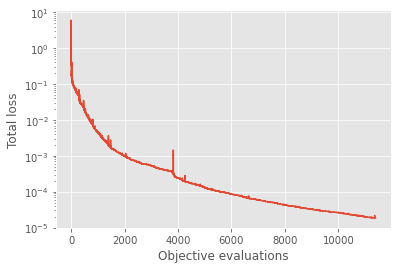

In [14]:
h = func.history
plt.figure()
plt.semilogy(h)
plt.xlabel('Objective evaluations')
plt.ylabel('Total loss');

# Use model to predict and compare with exact (simulated) answer
Load data from a simulation of the Burgers equation, and compare with the prediction of the neural network at some specific time.

In [15]:
# load the data from a simulation of the Burgers Equation
with h5py.File('burgersdata.h5','r') as fi:
    x_sim = fi['/scales/x/1.0'][:]
    t_sim = fi['scales']['sim_time'][:]
    uall_sim = fi['tasks']['u'][:]

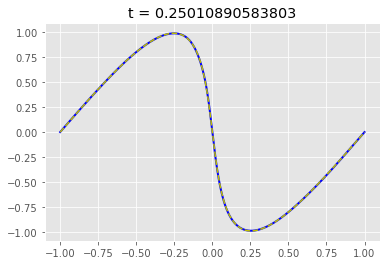

In [18]:
# set of t, x points
idx = 25
t_pred = np.ones_like(x_sim)

t_pred.fill(t_sim[idx])
X_test = np.stack((t_pred, x_sim), axis=1)

out = model(X_test)  # get the u values at these t, x values
plt.figure()
plt.plot(x_sim, out, 'b-', linewidth=2)
plt.plot(x_sim, uall_sim[idx, :], 'y--')
plt.title(f't = {t_sim[idx]:.14f}');

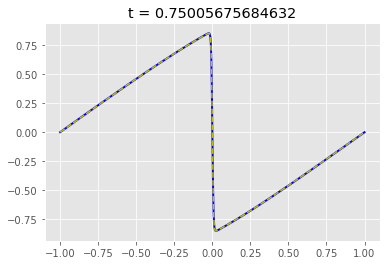

In [16]:
# set of t, x points
idx = 75
t_pred = np.ones_like(x_sim)

t_pred.fill(t_sim[idx])
X_test = np.stack((t_pred, x_sim), axis=1)

out = model(X_test)  # get the u values at these t, x values
plt.figure()
plt.plot(x_sim, out, 'b-', linewidth=2)
plt.plot(x_sim, uall_sim[idx, :], 'y--')
plt.title(f't = {t_sim[idx]:.14f}');

In [ ]:
Success!  The neural network gives very good predictions 

# Compute the RMS error of the PINN
at $t=0.75$.

In [21]:
idx = 75
u_target = uall_sim[idx, :]

t_pred = np.ones_like(x_sim)
t_pred.fill(t_sim[idx])
X_test = np.stack((t_pred, x_sim), axis=1)
u_pred = model(X_test).numpy().astype(dtype=np.float64)
u_pred = np.squeeze(u_pred)

err = u_pred - u_target
rms = np.sqrt(np.sum(err**2) / len(err))
print(f'rms error = {rms}')

rms error = 0.0010046846247476167
